In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import plot_counter
from collections import Counter
from nlp_utils import get_sentiment
from doc_utils import get_docs_by_location, get_docs_by_day, interleave_location_and_date
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
df = pd.read_csv("../../data/india-news-headlines.csv")

In [3]:
df.head(5)

,publish_date,headline_category,headline_text
0,20010101,sports.wwe,win over cena satisfying but defeating underta...
1,20010102,bollywood,Raju Chacha
2,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
3,20010102,unknown,Fissures in Hurriyat over Pak visit
4,20010102,unknown,America's unwanted heading for India?


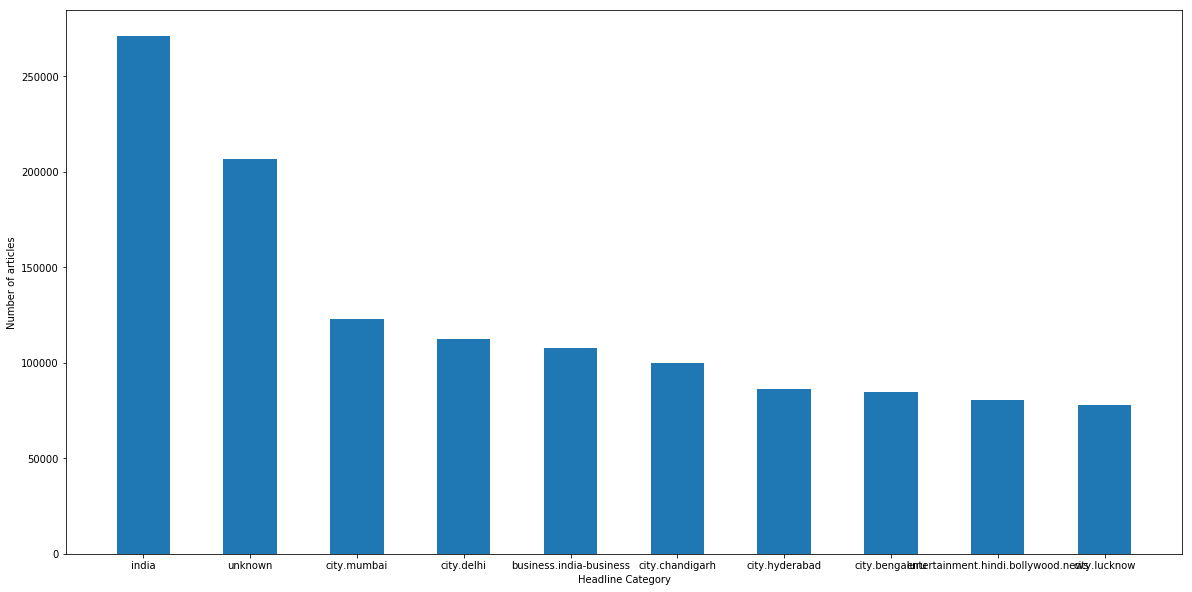

In [12]:
plot_counter(df.headline_category, xlabel="Headline Category",
             ylabel="Number of articles")

In [5]:
df.head(5)

,publish_date,headline_category,headline_text
0,20010101,sports.wwe,win over cena satisfying but defeating underta...
1,20010102,bollywood,Raju Chacha
2,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
3,20010102,unknown,Fissures in Hurriyat over Pak visit
4,20010102,unknown,America's unwanted heading for India?


In [6]:
def convert_to_datetime(df):
    """
    Input - A DF to convert df.publish_dates to to_datetime
    Returns - A converted DF
    """
    dates = df.publish_date
    del df['publish_date']
    dates = dates.apply(lambda x: str(x))
    dates = pd.to_datetime(dates)
    # This is kind of to match get_docs_by_day
    # over at tweet_utils
    df['created_at'] = dates
    return df


def filter_headlines(df, keywords):
    """
    Input - A DF for filtering headlines based on
            keywords
    Returns - Filtered DF
    """
    assert(keywords != None)
    assert(len(keywords) != 0)

    if isinstance(keywords, str):
        keywords = [keywords]

    resultant_df = pd.DataFrame(df.head(1).copy(deep=True), df.columns)

    # Iteratively apply the filter for each word
    for keyword in keywords:
        temp_df = df[df['headline_text'].str.contains(keyword, na=False)]
        print(keyword, "found in", temp_df.shape[0], "rows")
        resultant_df = resultant_df.append(temp_df.copy(deep=True))

    curr_len = len(resultant_df)
    resultant_df.drop_duplicates(inplace=True)

    print("Dropped", curr_len - len(resultant_df), "duplicate rows")

    return resultant_df

In [13]:
df = convert_to_datetime(df)

filtered_df = filter_headlines(
    df, ['bjp', 'govt', 'government', 'elect',
         'riot', 'protest', 'unrest', 'politic',
         'violen', 'scam', 'gang', 'modi', 'attac'])
print("Current shape:", filtered_df.shape)

bjp found in 150 rows
govt found in 35274 rows
government found in 11661 rows
elect found in 22416 rows
riot found in 5056 rows
protest found in 18492 rows
unrest found in 532 rows
politic found in 10998 rows
violen found in 5588 rows
scam found in 11700 rows
gang found in 9349 rows
modi found in 890 rows
attac found in 22155 rows
Dropped 4634 duplicate rows
Current shape: (149630, 3)


In [14]:
# Get news from 2016 and with city tag
filtered_df = filtered_df[filtered_df.headline_category.str.contains(
    'city', na=False)]
filtered_df = convert_to_datetime(filtered_df)

filtered_df = filtered_df[filtered_df.publish_date.dt.year > 2015]
print("Current shape:", filtered_df.shape)

Current shape: (33832, 3)


In [15]:
filtered_df.head(5)

,publish_date,headline_category,headline_text
2457153,2016-12-19,city.ahmedabad,bjp planning to advance gujarat assembly elect...
2471496,2017-01-09,city.mumbai,bjp silence on bmc pact worries senabjp silent...
2475103,2017-01-14,city.pune,bjp amp shiv sena hopeful of alliance for pimp...
2476394,2017-01-16,city.mumbai,hazare bjp mla get legal lessons over pilsanna...
2477628,2017-01-18,city.dehradun,protesting workers march to party office bjp r...


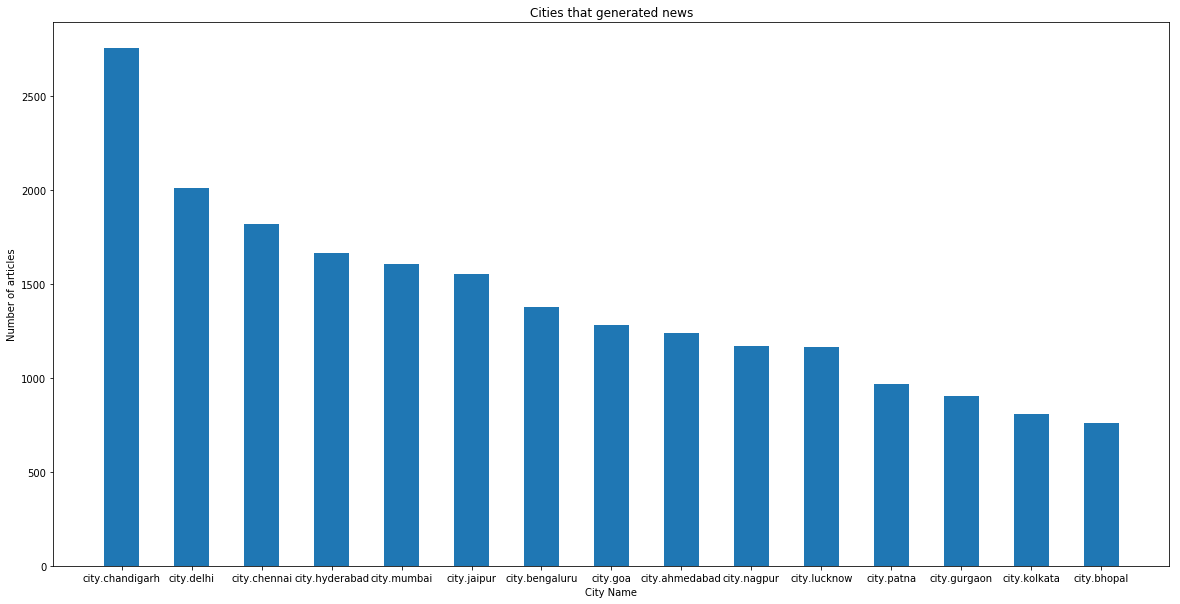

In [16]:
filtered_df.sort_values(by="publish_date", inplace=True)

plot_counter(filtered_df.headline_category, num_elements=15, title="Cities that generated news",
             xlabel="City Name", ylabel="Number of articles")

In [17]:
cities = pd.unique(filtered_df.headline_category)
for city in cities:
    city_df = filtered_df[filtered_df.headline_category == city]
    print(city)
    print("Min date:", min(city_df.publish_date).date())
    print("Max date:", max(city_df.publish_date).date())
    print()

city.chandigarh
Min date: 2016-01-01
Max date: 2018-12-31

city.jaipur
Min date: 2016-01-01
Max date: 2018-12-31

city.nagpur
Min date: 2016-01-01
Max date: 2018-12-26

city.trichy
Min date: 2016-01-01
Max date: 2018-12-28

city.vadodara
Min date: 2016-01-01
Max date: 2018-12-31

city.thiruvananthapuram
Min date: 2016-01-01
Max date: 2018-12-31

city.delhi
Min date: 2016-01-01
Max date: 2018-12-31

city.imphal
Min date: 2016-01-01
Max date: 2018-12-23

city.mumbai
Min date: 2016-01-01
Max date: 2018-12-29

city.chennai
Min date: 2016-01-01
Max date: 2018-12-31

city.indore
Min date: 2016-01-01
Max date: 2018-12-27

city.patna
Min date: 2016-01-01
Max date: 2018-12-31

city.hyderabad
Min date: 2016-01-01
Max date: 2018-12-30

city.gurgaon
Min date: 2016-01-01
Max date: 2018-12-29

city.goa
Min date: 2016-01-01
Max date: 2018-12-31

city.lucknow
Min date: 2016-01-01
Max date: 2018-12-31

city.pune
Min date: 2016-01-02
Max date: 2018-12-31

city.jamshedpur
Min date: 2016-01-02
Max date: 2

In [ ]:
# Do the same thing done in twitter
# for this as well

# TODO - Proceed with locations

location_date_dict = interleave_location_and_date(filtered_df, 
                                                  start_date=pd.to_datetime("1-jan-2016"),
                                                  end_date=pd.to_datetime("31-dec-2018"))

for city in cities:
    city_df = filtered_df[filtered_df.headline_category == city]
    sentiment_dict = get_sentiment(city_df.headline_text, range(len(city_df)))